<a href="https://colab.research.google.com/github/gabriel-picussa/Prova-1-CEP---Gabriel-Picussa/blob/main/GabrielPicussa_CEP_Prova_README.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP - Prova 1 - CEP**
##**Detec√ß√£o de intrus√£o de seguran√ßa cibern√©tica**
**Base:** cybersecurity_intrusion_data.csv  
**KPI principal (cont√≠nua):** `session_duration`  
**Amostragem:** 60 subgrupos racionais com n=5 (total 300 observa√ß√µes)

## Objetivo
Avaliar a **estabilidade do processo** (rede/sess√µes) via **Cartas de Shewhart XÃÑ‚ÄìR**, identificar causas especiais de varia√ß√£o e gerar os artefatos (gr√°ficos PNG e relat√≥rio PDF).

## Checklist inclu√≠do no notebook
1. Definir KPI cont√≠nua (`session_duration`).
2. Criar 60 subgrupos racionais (n=5) preservando a ordem.
3. Calcular por subgrupo: **XÃÑ** (m√©dia) e **R** (amplitude).
4. Calcular **XÃÑÃÑ** e **RÃÑ** e ent√£o os **limites de controle**:
   - XÃÑ: UCL = XÃÑÃÑ + A2¬∑RÃÑ ; CL = XÃÑÃÑ ; LCL = XÃÑÃÑ ‚àí A2¬∑RÃÑ
   - R:  UCL = D4¬∑RÃÑ ; CL = RÃÑ ; LCL = D3¬∑RÃÑ (para n=5, D3=0)
5. Plotar as cartas XÃÑ e R.
6. Listar pontos **fora de controle** e interpretar.
7. Salvar PNGs e gerar PDF com as figuras e resumo.


# **0) Instalar e configurar Kaggle usando URL direta do dataset**

**O que faz**: instala o cliente kaggle, grava kaggle.json com as credenciais (s√≥ para a sess√£o), cria a pasta de dados (/content/data_kaggle), interpreta a URL do Kaggle e baixa o dataset com kaggle datasets download, descompactando todos os .zip.

**Por qu√™:** padroniza o ambiente e automatiza o download para que o restante do pipeline encontre os arquivos localmente, sem cliques manuais.

In [25]:
import os, json, zipfile, glob, pathlib

# Instalar o cliente Kaggle
!pip -q install kaggle

# Credenciais Kaggle (somente nesta sess√£o do Colab)
kaggle_dir = pathlib.Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)
creds = {
    "username": "gabrielpicussa",
    "key": "0dcc5e253fd6527e08053a3378ba8317"
}
with open(kaggle_dir / "kaggle.json", "w") as f:
    json.dump(creds, f)
os.chmod(kaggle_dir / "kaggle.json", 0o600)

# Pasta de dados
DATA_DIR = "/content/data_kaggle"
os.makedirs(DATA_DIR, exist_ok=True)

# URL DIRETA informada por voc√™
KAGGLE_URL = "https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset"

# Baixar interpretando a URL
dataset_slug = KAGGLE_URL.split("/")[-1]
!kaggle datasets download -d dnkumars/$dataset_slug -p $DATA_DIR --force

# Descompactar os .zip baixados
for z in glob.glob(f"{DATA_DIR}/*.zip"):
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)

print(f"‚úÖ Dataset baixado e descompactado em: {DATA_DIR}")


Dataset URL: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset
License(s): MIT
  0% 0.00/261k [00:00<?, ?B/s]
100% 261k/261k [00:00<00:00, 451MB/s]
‚úÖ Dataset baixado e descompactado em: /content/data_kaggle


# **1) Imports, par√¢metros e localiza√ß√£o do CSV**

**O que faz**: importa pandas/numpy/matplotlib, ajusta display/figuras, define par√¢metros de CEP: KPI_NAME='session_duration', M=60 subgrupos, N=5 por subgrupo, e as constantes A2=0.577, D3=0.0, D4=2.114 (v√°lidas para n=5). Cria OUT_DIR. Varre recursivamente DATA_DIR atr√°s de CSV e escolhe o mais prov√°vel (nome contendo ‚Äúintrusion‚Äù/‚Äúcyber‚Äù).

**Por qu√™**: fixa o cen√°rio do CEP XÃÑ‚ÄìR e garante descoberta robusta do arquivo, mesmo se o dataset vier em m√∫ltiplas pastas.

In [26]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os, glob

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.dpi"] = 120

# Par√¢metros CEP
KPI_NAME = "session_duration"   # vari√°vel cont√≠nua principal
M = 60                          # <-- voc√™ pediu 60 amostras
N = 5                           # tamanho do subgrupo (permanece 5)
A2 = 0.577                      # constantes para n=5
D3 = 0.0
D4 = 2.114

OUT_DIR = "/content/cep_output"
os.makedirs(OUT_DIR, exist_ok=True)

# Localizar CSV automaticamente
csv_candidates = sorted(glob.glob(f"{DATA_DIR}/**/*.csv", recursive=True))
pref = [p for p in csv_candidates if ("intrusion" in os.path.basename(p).lower() or
                                      "cyber" in os.path.basename(p).lower())]
CSV_PATH = pref[0] if pref else (csv_candidates[0] if csv_candidates else "")

if not CSV_PATH:
    raise FileNotFoundError("Nenhum CSV foi encontrado ap√≥s baixar/descompactar o dataset do Kaggle.")

print("‚úÖ CSV selecionado:", CSV_PATH)


‚úÖ CSV selecionado: /content/data_kaggle/cybersecurity_intrusion_data.csv


# **2) Carregar dados e preparar KPI (garante 60√ó5 = 300 observa√ß√µes)**

**O que faz**: l√™ o CSV, verifica se a coluna session_duration existe, for√ßa num√©rico, tenta ordenar por uma coluna temporal (se houver) para preservar sequ√™ncia, remove NaN, e garante pelo menos 300 observa√ß√µes (M√óN). Seleciona as primeiras 300 preservando a ordem.

**Por qu√™:** CEP requer dados em sequ√™ncia temporal/operacional e tamanho de amostra coerente com o plano de subagrupamento.

In [27]:
df_raw = pd.read_csv(CSV_PATH)

if KPI_NAME not in df_raw.columns:
    raise ValueError(
        f"A coluna '{KPI_NAME}' n√£o foi encontrada no CSV.\n"
        f"Algumas colunas dispon√≠veis: {list(df_raw.columns)[:20]}"
    )

df = df_raw.copy()
df[KPI_NAME] = pd.to_numeric(df[KPI_NAME], errors="coerce")

# Ordenar por tempo se existir coluna temporal plaus√≠vel
time_cols = [c for c in df.columns if any(k in c.lower() for k in ["time", "date", "timestamp"])]
if time_cols:
    sort_col = time_cols[0]
    try:
        df[sort_col] = pd.to_datetime(df[sort_col], errors="coerce")
        df = df.sort_values(by=sort_col, kind="mergesort").reset_index(drop=True)
    except Exception:
        df = df.reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# Manter somente a KPI e remover NaN
df_kpi = df[[KPI_NAME]].dropna().reset_index(drop=True)

needed = M * N  # 60*5 = 300
if len(df_kpi) < needed:
    raise ValueError(
        f"Para M={M} e N={N}, s√£o necess√°rias {needed} observa√ß√µes n√£o nulas em '{KPI_NAME}'. "
        f"Foram encontradas {len(df_kpi)}. "
        f"Sugest√µes: aumentar M (p/ menor) ou escolher outra KPI com mais dados."
    )

# Selecionar as primeiras 300 observa√ß√µes preservando a ordem
df_kpi = df_kpi.iloc[:needed].copy().reset_index(drop=True)
print(f"‚úÖ Dados prontos: {len(df_kpi)} observa√ß√µes ({M} subgrupos √ó {N}).")
df_kpi.head()


‚úÖ Dados prontos: 300 observa√ß√µes (60 subgrupos √ó 5).


session_duration
0        492.983263
1       1557.996461
2         75.044262
3        601.248835
4        532.540888

# **3) Subgrupos, XÃÑ, R e limites de controle**

**O que faz**: etiqueta as linhas com sample=1..M (cada amostra tem N linhas), calcula XÃÑ·µ¢ (m√©dia do subgrupo) e R·µ¢ (m√°x‚Äìm√≠n). Em seguida:

XÃÑÃÑ = m√©dia de XÃÑ·µ¢ (m√©dia das m√©dias)

RÃÑ = m√©dia de R·µ¢ (m√©dia das amplitudes)

Limites XÃÑ: UCL‚Çì = XÃÑÃÑ + A2¬∑RÃÑ, CL‚Çì = XÃÑÃÑ, LCL‚Çì = XÃÑÃÑ ‚àí A2¬∑RÃÑ

Limites R: UCL·µ£ = D4¬∑RÃÑ, CL·µ£ = RÃÑ, LCL·µ£ = D3¬∑RÃÑ

**Por qu√™:** s√£o as f√≥rmulas cl√°ssicas de CEP para cartas XÃÑ‚ÄìR com subgrupos de tamanho N=5.

In [28]:
# Atribuir r√≥tulo de amostra 1..M, cada uma com N linhas
df_kpi["sample"] = np.repeat(np.arange(1, M+1), N)

grouped = df_kpi.groupby("sample")[KPI_NAME]
xbar = grouped.mean()
r_i = grouped.max() - grouped.min()

# Estat√≠sticas globais
Xbarbar = xbar.mean()
Rbar = r_i.mean()

# Limites de controle
UCL_x = Xbarbar + A2 * Rbar
LCL_x = Xbarbar - A2 * Rbar
CL_x  = Xbarbar

UCL_r = D4 * Rbar
LCL_r = D3 * Rbar
CL_r  = Rbar

summary_limits = pd.DataFrame({
    "Carta": ["XÃÑ", "R"],
    "LCL":   [LCL_x, LCL_r],
    "CL":    [CL_x,  CL_r],
    "UCL":   [UCL_x, UCL_r],
    "XÃÑÃÑ/RÃÑ": [Xbarbar, Rbar]
})
print("Resumo dos limites:")
display(summary_limits)


Resumo dos limites:


Carta        LCL           CL          UCL       XÃÑÃÑ/RÃÑ
0    XÃÑ -93.789191   862.176205  1818.141601   862.176205
1     R   0.000000  1656.785781  3502.445142  1656.785781

# **4) Fun√ß√µes de plot com eixo ajustado e marca√ß√£o de 5 em 5**

**O que faz:** define plot_xbar_ooc e plot_r_ooc, que:

Tra√ßam a s√©rie por amostra com marcadores;

Desenham UCL/CL/LCL (CL em linha cont√≠nua, UCL/LCL tracejadas);

Sinalizam OOC (fora de controle) em vermelho (XÃÑ·µ¢ ou R·µ¢ al√©m dos limites);

Ajustam eixo X para come√ßar em 0 e ir at√© M+1, com ticks de 5 em 5;

Salvam a figura em PNG (opcional) e exibem.

**Por qu√™:** padroniza est√©tica, destaca OOC e produz arquivos reutiliz√°veis (PDF/report).

In [29]:
def plot_xbar_ooc(xbar_series, CL, UCL, LCL, kpi_name, savepath=None):
    idx = xbar_series.index.values
    vals = xbar_series.values
    ooc_mask = (xbar_series > UCL) | (xbar_series < LCL)

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(idx, vals, marker="o", linewidth=1, label="XÃÑ (por amostra)")
    ax.scatter(idx[ooc_mask], vals[ooc_mask], s=60, c="red", zorder=3, label="Fora de controle")

    # Linhas horizontais
    ax.axhline(UCL, linestyle="--", color="black", label=f"UCL = {UCL:.2f}")
    ax.axhline(CL,  linestyle="-",  color="tab:green", label=f"CL = {CL:.2f}")
    ax.axhline(LCL, linestyle="--", color="black", label=f"LCL = {LCL:.2f}")

    # Eixo X come√ßa em 0 e vai at√© M+1
    ax.set_xlim(0, len(idx) + 1)
    ax.set_xticks(np.arange(0, len(idx) + 1, 5))  # marca√ß√£o de 5 em 5

    ax.set_title(f"Carta XÃÑ ‚Äî {kpi_name} (n={N}, m={M})", fontsize=12)
    ax.set_xlabel(f"Amostra (0..{M})", fontsize=10)
    ax.set_ylabel("M√©dia por subgrupo", fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.6)
    ax.legend(loc="best", fontsize=9, ncol=2)
    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=150)
    plt.show()
    return savepath


def plot_r_ooc(r_series, CL, UCL, LCL, kpi_name, savepath=None):
    idx = r_series.index.values
    vals = r_series.values
    ooc_mask = (r_series > UCL) | (r_series < LCL)

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(idx, vals, marker="o", linewidth=1, label="R (por amostra)")
    ax.scatter(idx[ooc_mask], vals[ooc_mask], s=60, c="red", zorder=3, label="Fora de controle")

    # Linhas horizontais
    ax.axhline(UCL, linestyle="--", color="black", label=f"UCL = {UCL:.2f}")
    ax.axhline(CL,  linestyle="-",  color="tab:green", label=f"CL = {CL:.2f}")
    ax.axhline(LCL, linestyle="--", color="black", label=f"LCL = {LCL:.2f}")

    # Eixo ajustado e espa√ßamento 5 em 5
    ax.set_xlim(0, len(idx) + 1)
    ax.set_xticks(np.arange(0, len(idx) + 1, 5))

    ax.set_title(f"Carta R ‚Äî {kpi_name} (n={N}, m={M})", fontsize=12)
    ax.set_xlabel(f"Amostra (0..{M})", fontsize=10)
    ax.set_ylabel("Amplitude por subgrupo (max-min)", fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.6)
    ax.legend(loc="best", fontsize=9, ncol=2)
    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=150)
    plt.show()
    return savepath


# **5) Gerar e EXIBIR as cartas + salvar PNG**

**O que faz**: monta os caminhos de sa√≠da, chama as fun√ß√µes de plot para XÃÑ e R, grava em OUT_DIR e imprime os caminhos.

**Por qu√™:** materializa os gr√°ficos para an√°lise e para compor o relat√≥rio.

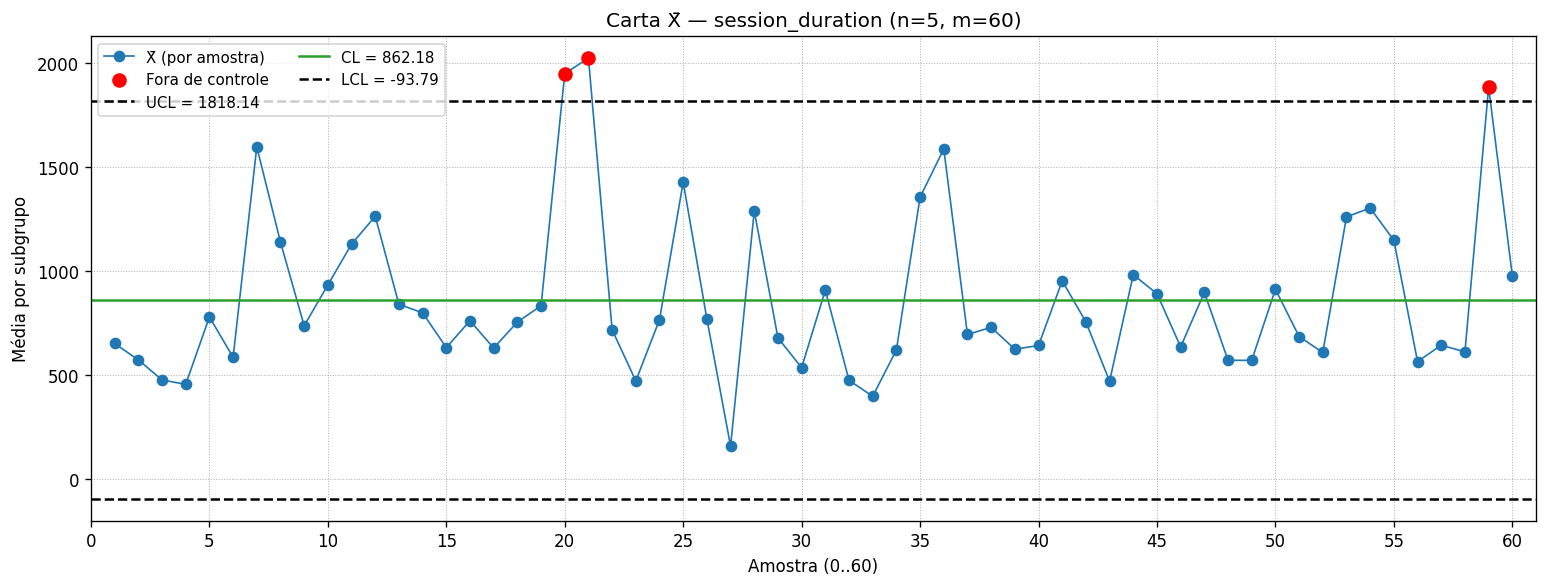

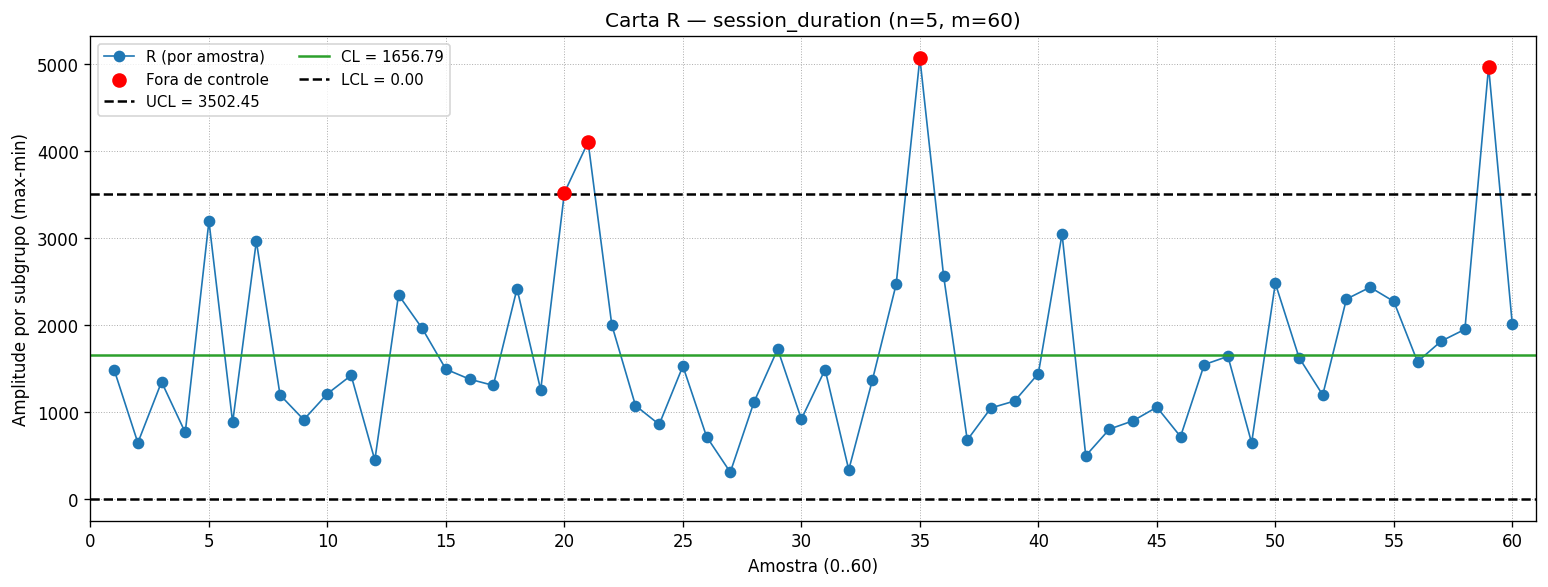

Arquivos PNG salvos em:
- /content/cep_output/xbar_session_duration_m60_n5.png
- /content/cep_output/r_session_duration_m60_n5.png


In [30]:
xbar_png = os.path.join(OUT_DIR, f"xbar_{KPI_NAME}_m{M}_n{N}.png")
r_png = os.path.join(OUT_DIR, f"r_{KPI_NAME}_m{M}_n{N}.png")

plot_xbar_ooc(xbar, CL_x, UCL_x, LCL_x, KPI_NAME, savepath=xbar_png)
plot_r_ooc(r_i, CL_r, UCL_r, LCL_r, KPI_NAME, savepath=r_png)

print("Arquivos PNG salvos em:")
print("-", xbar_png)
print("-", r_png)


# **6) Detectar pontos fora de controle + diagn√≥stico**

**O que faz**: cria m√°scaras OOC:

xbar_ooc = {XÃÑ·µ¢ | XÃÑ·µ¢>UCL‚Çì ou XÃÑ·µ¢<LCL‚Çì}

r_ooc = {R·µ¢ | R·µ¢>UCL·µ£ ou R·µ¢<LCL·µ£}
Exibe tabelas (quando houver) com amostra e valor e monta um diagn√≥stico textual:

se nada OOC: ‚ÄúProcesso sob controle (regra 3-sigma)‚Äù;

OOC em XÃÑ: suspeita de mudan√ßa de n√≠vel/m√©dia entre subgrupos;

OOC em R: suspeita de mudan√ßa de variabilidade intra-subgrupo.

**Por que**: traduz automaticamente o achado gr√°fico em sinais pr√°ticos de investiga√ß√£o.

In [31]:
xbar_ooc = xbar[(xbar > UCL_x) | (xbar < LCL_x)]
r_ooc = r_i[(r_i > UCL_r) | (r_i < LCL_r)]

print("==== PONTOS FORA DE CONTROLE ‚Äî CARTA XÃÑ ====")
if xbar_ooc.empty:
    print("Nenhum ponto fora de controle na XÃÑ.")
else:
    display(pd.DataFrame({"Amostra": xbar_ooc.index, "XÃÑ": xbar_ooc.values}).reset_index(drop=True))

print("\n==== PONTOS FORA DE CONTROLE ‚Äî CARTA R ====")
if r_ooc.empty:
    print("Nenhum ponto fora de controle na R.")
else:
    display(pd.DataFrame({"Amostra": r_ooc.index, "R": r_ooc.values}).reset_index(drop=True))

diagnostico = []
if xbar_ooc.empty and r_ooc.empty:
    diagnostico.append("Processo sob controle estat√≠stico (regra 3-sigma).")
if not xbar_ooc.empty:
    diagnostico.append("Altera√ß√£o de m√©dia entre subgrupos (XÃÑ). Investigar causas especiais.")
if not r_ooc.empty:
    diagnostico.append("Altera√ß√£o da variabilidade intra-subgrupo (R). Verificar mistura de condi√ß√µes.")

print("\n==== DIAGN√ìSTICO INICIAL ====")
for item in diagnostico:
    print("-", item)


==== PONTOS FORA DE CONTROLE ‚Äî CARTA XÃÑ ====


Amostra           XÃÑ
0       20  1948.944347
1       21  2024.172715
2       59  1883.818108


==== PONTOS FORA DE CONTROLE ‚Äî CARTA R ====


Amostra            R
0       20  3520.783630
1       21  4103.769827
2       35  5070.472963
3       59  4969.990991


==== DIAGN√ìSTICO INICIAL ====
- Altera√ß√£o de m√©dia entre subgrupos (XÃÑ). Investigar causas especiais.
- Altera√ß√£o da variabilidade intra-subgrupo (R). Verificar mistura de condi√ß√µes.


# **7) Gerar PDF e baixar imagens PNG em alta resolu√ß√£o**
**O que faz:** regrava as figuras em 300 dpi, cria um PDF com:

P√°gina da Carta XÃÑ (imagem);

P√°gina da Carta R (imagem);

P√°gina de Resumo textual (KPI, M√óN, limites formatados, pontos OOC e diagn√≥stico).
Depois aciona files.download para baixar os PNGs.

**Por qu√™:** entrega um relat√≥rio port√°til para anexar/compartilhar e os PNGs em alta para apresenta√ß√µes.

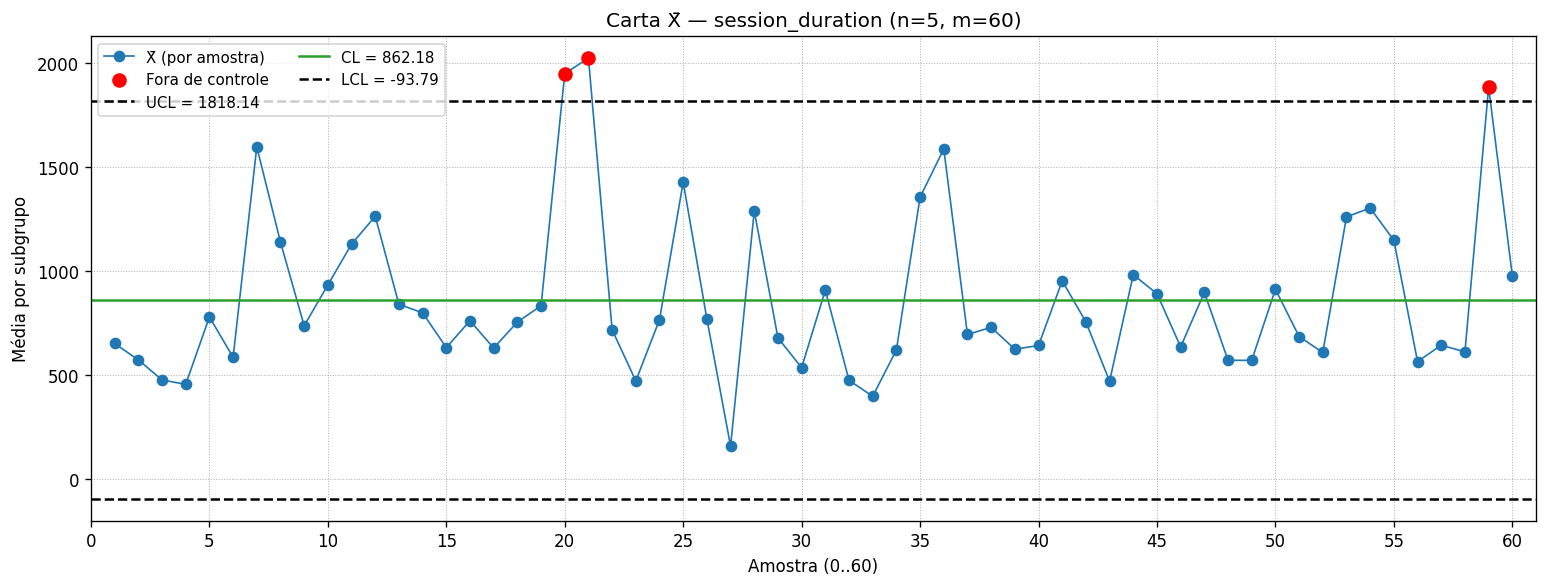

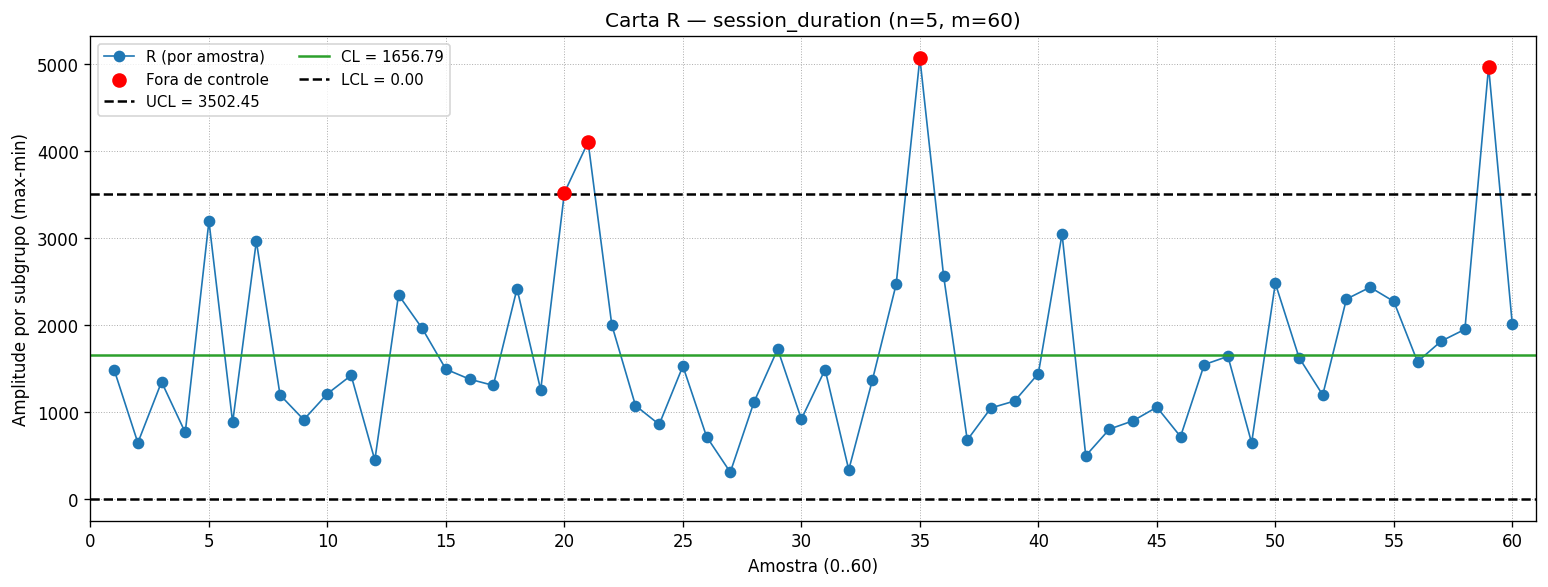

üìÑ PDF gerado em: /content/cep_output/CEP_report_session_duration_m60_n5_20251020_012819.pdf
üñºÔ∏è Imagens em alta resolu√ß√£o salvas:
- /content/cep_output/xbar_session_duration_m60_n5.png
- /content/cep_output/r_session_duration_m60_n5.png
Resumo dos limites de CONTROLE (Cartas XÃÑ e R):


Carta        LCL           CL          UCL       XÃÑÃÑ/RÃÑ
0    XÃÑ -93.789191   862.176205  1818.141601   862.176205
1     R   0.000000  1656.785781  3502.445142  1656.785781


Limites de controle ‚Äî Carta XÃÑ
LIC (LCL_x) = -93.79
LC  (CL_x)  = 862.18
LSC (UCL_x) = 1818.14

Limites de controle ‚Äî Carta R
LIC (LCL_r) = 0.00
LC  (CL_r)  = 1656.79
LSC (UCL_r) = 3502.45

‚¨áÔ∏è Iniciando download dos arquivos PNG...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

‚úÖ Downloads conclu√≠dos!


In [32]:
from google.colab import files

# Caminhos dos arquivos PNG existentes
xbar_png = os.path.join(OUT_DIR, f"xbar_{KPI_NAME}_m{M}_n{N}.png")
r_png    = os.path.join(OUT_DIR, f"r_{KPI_NAME}_m{M}_n{N}.png")

# Regravar as figuras em ALTA RESOLU√á√ÉO (300 dpi)
plot_xbar_ooc(xbar, CL_x, UCL_x, LCL_x, KPI_NAME, savepath=xbar_png)
plot_r_ooc(r_i, CL_r, UCL_r, LCL_r, KPI_NAME, savepath=r_png)

# Caminho do PDF
pdf_path = os.path.join(
    OUT_DIR,
    f"CEP_report_{KPI_NAME}_m{M}_n{N}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"
)

# === Gera√ß√£o do PDF (como antes) ===
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

with PdfPages(pdf_path) as pdf:
    # P√°gina 1 ‚Äî Carta XÃÑ
    fig1 = plt.figure(figsize=(11, 8.5))
    img = plt.imread(xbar_png)
    plt.imshow(img); plt.axis('off'); plt.title("Carta XÃÑ")
    pdf.savefig(fig1); plt.close(fig1)

    # P√°gina 2 ‚Äî Carta R
    fig2 = plt.figure(figsize=(11, 8.5))
    img2 = plt.imread(r_png)
    plt.imshow(img2); plt.axis('off'); plt.title("Carta R")
    pdf.savefig(fig2); plt.close(fig2)

    # P√°gina 3 ‚Äî Resumo textual
    fig3 = plt.figure(figsize=(11, 8.5))
    plt.axis("off")
    lines = []
    lines.append("Relat√≥rio ‚Äî CEP (Cartas XÃÑ‚ÄìR)")
    lines.append(f"KPI: {KPI_NAME}")
    lines.append(f"Subgrupos: {M} √ó {N}  (total {M*N} observa√ß√µes)")
    lines.append("")
    lines.append("Resumo dos Limites:")
    for _, row in summary_limits.iterrows():
        lines.append(f"- {row['Carta']}: LCL={row['LCL']:.6g}, CL={row['CL']:.6g}, UCL={row['UCL']:.6g}")
    lines.append("")
    lines.append("Pontos fora de controle ‚Äî XÃÑ:")
    if xbar_ooc.empty:
        lines.append("- Nenhum")
    else:
        for idx, val in xbar_ooc.items():
            lines.append(f"- Amostra {int(idx)}: XÃÑ={val:.6g}")
    lines.append("")
    lines.append("Pontos fora de controle ‚Äî R:")
    if r_ooc.empty:
        lines.append("- Nenhum")
    else:
        for idx, val in r_ooc.items():
            lines.append(f"- Amostra {int(idx)}: R={val:.6g}")
    lines.append("")
    lines.append("Diagn√≥stico inicial:")
    if diagnostico:
        for d in diagnostico:
            lines.append(f"- {d}")
    else:
        lines.append("- (sem observa√ß√µes)")

    plt.text(0.01, 0.99, "\n".join(lines), va="top", fontsize=10, family="monospace")
    pdf.savefig(fig3); plt.close(fig3)

print(f"üìÑ PDF gerado em: {pdf_path}")
print("üñºÔ∏è Imagens em alta resolu√ß√£o salvas:")
print("-", xbar_png)
print("-", r_png)
print("Resumo dos limites de CONTROLE (Cartas XÃÑ e R):")
display(summary_limits)

# --- Exibir valores em texto, com a MESMA formata√ß√£o dos gr√°ficos (2 casas) ---
print("\nLimites de controle ‚Äî Carta XÃÑ")
print(f"LIC (LCL_x) = {LCL_x:.2f}")
print(f"LC  (CL_x)  = {CL_x:.2f}")
print(f"LSC (UCL_x) = {UCL_x:.2f}")

print("\nLimites de controle ‚Äî Carta R")
print(f"LIC (LCL_r) = {LCL_r:.2f}")
print(f"LC  (CL_r)  = {CL_r:.2f}")
print(f"LSC (UCL_r) = {UCL_r:.2f}")


# === DOWNLOAD AUTOM√ÅTICO DAS IMAGENS ===
print("\n‚¨áÔ∏è Iniciando download dos arquivos PNG...")
files.download(xbar_png)
files.download(r_png)
print("‚úÖ Downloads conclu√≠dos!")


# **8) An√°lise de Pontos Fora de Controle (XÃÑ e R)**

Neste passo, o c√≥digo identificou tr√™s amostras fora de controle na carta XÃÑ (20, 21 e 59) e quatro amostras na carta R (20, 21, 35 e 59), todas acima do limite superior (UCL). Esses resultados mostram que houve varia√ß√µes significativas tanto na m√©dia quanto na amplitude de algumas amostras, indicando poss√≠veis causas especiais atuando no processo. A identifica√ß√£o dessas amostras √© fundamental para direcionar a investiga√ß√£o das anomalias e entender se elas s√£o pontuais ou sistem√°ticas.

O resumo mostra que 5% das amostras da carta XÃÑ e 6,6% da carta R ultrapassaram os limites de controle, sugerindo instabilidade estat√≠stica. Os arquivos gerados em formato CSV registram essas ocorr√™ncias, permitindo an√°lise posterior ou inser√ß√£o em relat√≥rios. Dessa forma, o Passo 8 marca o in√≠cio da etapa de diagn√≥stico, transformando os c√°lculos de controle em informa√ß√µes objetivas sobre o comportamento do processo.

In [33]:

import pandas as pd
import numpy as np
import os

# (Re)usa s√©ries e limites calculados antes:
# xbar, r_i, UCL_x, LCL_x, CL_x, UCL_r, LCL_r, CL_r, OUT_DIR

def _rotulo_direcao(val, LCL, UCL):
    if val > UCL: return "Acima do UCL"
    if val < LCL: return "Abaixo do LCL"
    return "Dentro"

# M√°scaras OOC
mask_x_ooc = (xbar > UCL_x) | (xbar < LCL_x)
mask_r_ooc = (r_i  > UCL_r) | (r_i  < LCL_r)

# Tabelas detalhadas
tbl_x_ooc = pd.DataFrame({
    "Amostra": xbar.index[mask_x_ooc].astype(int),
    "XÃÑ":      xbar[mask_x_ooc].values,
    "Dire√ß√£o": [ _rotulo_direcao(v, LCL_x, UCL_x) for v in xbar[mask_x_ooc].values ]
}).reset_index(drop=True)

tbl_r_ooc = pd.DataFrame({
    "Amostra": r_i.index[mask_r_ooc].astype(int),
    "R":      r_i[mask_r_ooc].values,
    "Dire√ß√£o": [ _rotulo_direcao(v, LCL_r, UCL_r) for v in r_i[mask_r_ooc].values ]
}).reset_index(drop=True)

# Resumo quantitativo
total_samples = len(xbar)
resumo = pd.DataFrame({
    "Carta": ["XÃÑ","R"],
    "Qtd OOC": [len(tbl_x_ooc), len(tbl_r_ooc)],
    "% OOC":   [100*len(tbl_x_ooc)/total_samples, 100*len(tbl_r_ooc)/total_samples]
})

print("==== PONTOS FORA DE CONTROLE ‚Äî CARTA XÃÑ ====")
display(tbl_x_ooc if not tbl_x_ooc.empty else pd.DataFrame(columns=["Amostra","XÃÑ","Dire√ß√£o"]))
print("\n==== PONTOS FORA DE CONTROLE ‚Äî CARTA R ====")
display(tbl_r_ooc if not tbl_r_ooc.empty else pd.DataFrame(columns=["Amostra","R","Dire√ß√£o"]))
print("\n==== RESUMO ====")
display(resumo)

# Salva para o relat√≥rio
ooc_x_csv = os.path.join(OUT_DIR, "ooc_xbar.csv")
ooc_r_csv = os.path.join(OUT_DIR, "ooc_r.csv")
resumo_csv = os.path.join(OUT_DIR, "ooc_resumo.csv")
tbl_x_ooc.to_csv(ooc_x_csv, index=False)
tbl_r_ooc.to_csv(ooc_r_csv, index=False)
resumo.to_csv(resumo_csv, index=False)

print(f"\nArquivos salvos:\n- {ooc_x_csv}\n- {ooc_r_csv}\n- {resumo_csv}")


==== PONTOS FORA DE CONTROLE ‚Äî CARTA XÃÑ ====


Amostra           XÃÑ       Dire√ß√£o
0       20  1948.944347  Acima do UCL
1       21  2024.172715  Acima do UCL
2       59  1883.818108  Acima do UCL


==== PONTOS FORA DE CONTROLE ‚Äî CARTA R ====


Amostra            R       Dire√ß√£o
0       20  3520.783630  Acima do UCL
1       21  4103.769827  Acima do UCL
2       35  5070.472963  Acima do UCL
3       59  4969.990991  Acima do UCL


==== RESUMO ====


Carta  Qtd OOC     % OOC
0    XÃÑ        3  5.000000
1     R        4  6.666667


Arquivos salvos:
- /content/cep_output/ooc_xbar.csv
- /content/cep_output/ooc_r.csv
- /content/cep_output/ooc_resumo.csv


# **9) Interpreta√ß√£o dos Resultados**

Com base nos resultados do Passo 8, o Passo 9 apresentou um diagn√≥stico que confirma a presen√ßa de causas especiais de varia√ß√£o. O relat√≥rio gerado automaticamente listou as mesmas amostras fora dos limites, refor√ßando que as amostras 20, 21 e 59 apresentaram desvios na m√©dia, enquanto as amostras 20, 21, 35 e 59 mostraram dispers√µes elevadas dentro dos subgrupos. Esse padr√£o indica que h√° instabilidades tanto no n√≠vel do processo quanto na consist√™ncia das medi√ß√µes.

As a√ß√µes recomendadas incluem revisar ajustes recentes de m√°quina, verificar calibra√ß√£o de instrumentos e checar poss√≠veis altera√ß√µes de mat√©ria-prima ou de turno. Tamb√©m √© indicado investigar fontes de variabilidade intra-subgrupo, especialmente nas amostras com R fora de controle. O objetivo √© identificar e eliminar as causas especiais, para que o processo retorne a um estado de controle est√°vel e previs√≠vel.

In [34]:

# OPCIONAL: defina especifica√ß√µes, se aplic√°vel √† sua KPI.
# Se n√£o houver especifica√ß√µes formais, deixe como None.
LIE = None   # ex.: 490.0
LSE = None   # ex.: 510.0

def interpretar_processo(xbar, r_i, LCL_x, UCL_x, LCL_r, UCL_r, LIE=None, LSE=None):
    # OOC
    x_ooc_idx = xbar[(xbar > UCL_x) | (xbar < LCL_x)]
    r_ooc_idx = r_i[(r_i > UCL_r) | (r_i < LCL_r)]
    sob_controle = x_ooc_idx.empty and r_ooc_idx.empty

    linhas = []
    linhas.append("DIAGN√ìSTICO DO CEP (XÃÑ‚ÄìR)")
    linhas.append("-" * 40)
    if sob_controle:
        linhas.append("‚Ä¢ Processo sob controle estat√≠stico (regra 3-sigma).")
    else:
        linhas.append("‚Ä¢ Evid√™ncias de causas especiais de varia√ß√£o:")
        if not x_ooc_idx.empty:
            linhas.append("  - Carta XÃÑ: " + ", ".join([f"Amostra {int(i)} (XÃÑ={v:.4g})" for i,v in x_ooc_idx.items()]))
        if not r_ooc_idx.empty:
            linhas.append("  - Carta R: " + ", ".join([f"Amostra {int(i)} (R={v:.4g})" for i,v in r_ooc_idx.items()]))

    # Rela√ß√£o com especifica√ß√µes (se dispon√≠veis)
    if (LIE is not None) and (LSE is not None):
        # Aproxima√ß√£o simples: compara m√©dias de subgrupo (XÃÑ) aos limites de especifica√ß√£o
        prop_xbar_fora_espec = np.mean((xbar < LIE) | (xbar > LSE))
        linhas.append("-" * 40)
        linhas.append("LIMITES DE ESPECIFICA√á√ÉO (opcional)")
        linhas.append(f"‚Ä¢ LIE={LIE}, LSE={LSE}")
        linhas.append(f"‚Ä¢ Propor√ß√£o de m√©dias de subgrupo fora de especifica√ß√£o: {100*prop_xbar_fora_espec:.2f}%")
        linhas.append("‚Ä¢ Observa√ß√£o: limites de controle medem estabilidade; limites de especifica√ß√£o medem conformidade.")

    # A√ß√µes corretivas sugeridas (gen√©ricas)
    linhas.append("-" * 40)
    linhas.append("A√á√ïES RECOMENDADAS")
    if sob_controle:
        linhas.append("‚Ä¢ Manter condi√ß√µes atuais e monitorar rotineiramente; avaliar capabilidade (Cp/Cpk) se houver especifica√ß√µes.")
    else:
        linhas.append("‚Ä¢ Investigar ajustes recentes de m√°quina/setup pr√≥ximos √†s amostras sinalizadas.")
        linhas.append("‚Ä¢ Verificar instrumento de medi√ß√£o e calibra√ß√£o.")
        linhas.append("‚Ä¢ Revisar mat√©ria-prima/lotes e mudan√ßas de turno/equipe.")
        linhas.append("‚Ä¢ Se R estiver OOC: focar em fontes de variabilidade intra-subgrupo (mistura de condi√ß√µes).")
        linhas.append("‚Ä¢ Ap√≥s a a√ß√£o, coletar nova amostra para verifica√ß√£o de retorno ao controle.")

    return "\n".join(linhas)

print(interpretar_processo(xbar, r_i, LCL_x, UCL_x, LCL_r, UCL_r, LIE=LIE, LSE=LSE))


DIAGN√ìSTICO DO CEP (XÃÑ‚ÄìR)
----------------------------------------
‚Ä¢ Evid√™ncias de causas especiais de varia√ß√£o:
  - Carta XÃÑ: Amostra 20 (XÃÑ=1949), Amostra 21 (XÃÑ=2024), Amostra 59 (XÃÑ=1884)
  - Carta R: Amostra 20 (R=3521), Amostra 21 (R=4104), Amostra 35 (R=5070), Amostra 59 (R=4970)
----------------------------------------
A√á√ïES RECOMENDADAS
‚Ä¢ Investigar ajustes recentes de m√°quina/setup pr√≥ximos √†s amostras sinalizadas.
‚Ä¢ Verificar instrumento de medi√ß√£o e calibra√ß√£o.
‚Ä¢ Revisar mat√©ria-prima/lotes e mudan√ßas de turno/equipe.
‚Ä¢ Se R estiver OOC: focar em fontes de variabilidade intra-subgrupo (mistura de condi√ß√µes).
‚Ä¢ Ap√≥s a a√ß√£o, coletar nova amostra para verifica√ß√£o de retorno ao controle.
